<a href="https://colab.research.google.com/github/ElAm1ne/March--Fi-2/blob/master/SuperHedge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



---


Installe automatiquement les librairies manquantes à l'execution du programme

***(peut prendre 5 à 10 minutes si aucune des librairies n'est déjà installée)***

---



In [ ]:
import sys
import subprocess
import pkg_resources

required = {'scipy', 'numpy', 'pandas', 'openpyxl', 'numba', 'matplotlib', 'plotly', 'seaborn','scikit-learn'}
installed = {pkg.key for pkg in pkg_resources.working_set}
missing = required - installed

if missing:
    python = sys.executable
    subprocess.check_call([python, '-m', 'pip', 'install', *missing], stdout=subprocess.DEVNULL)

import pandas as pd
import numpy as np
import math
import numba as nb
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from sys import argv
import os
from scipy import stats
import plotly.graph_objects as go
from plotly.graph_objs import Candlestick
from numba import jit, types
from numba.typed import List
from numba.extending import get_cython_function_address
from numba import vectorize, njit
import ctypes
import plotly.express as px
from scipy.interpolate import griddata
from scipy.stats.stats import pearsonr   
import seaborn as sns
from sklearn.linear_model import LinearRegression

---

***(Lecture du fichier : Base Yahoo Finance données CAC40 de Janvier 2020 à Janvier 2023, prix : Open, Close, High, Low)***

---

In [ ]:
if not os.path.exists('data.csv'):
  !wget https://raw.githubusercontent.com/ElAm1ne/March--Fi-2/master/data.csv
file = 'data.csv'
df = pd.read_csv(file)
df = df.dropna(subset=['Adj Close', 'High', 'Low', 'Open'])

prices = df["Adj Close"].to_numpy(dtype = np.float64)
highs = df["High"].to_numpy(dtype = np.float64)
lows = df["Low"].to_numpy(dtype = np.float64)
opens = df["Open"].to_numpy(dtype = np.float64)


--2023-01-04 03:26:08--  https://raw.githubusercontent.com/ElAm1ne/March--Fi-2/master/data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 465486 (455K) [text/plain]
Saving to: ‘data.csv’

data.csv            100%[===================>] 454.58K  --.-KB/s    in 0.02s   

2023-01-04 03:26:09 (19.0 MB/s) - ‘data.csv’ saved [465486/465486]



---


Calcul la valeur critique de l'interval de confiance en utilisant la fonction de répartition de la loi student, fonction compilée et executée en Fortran wrapper en C ensuite éxecutée Python.

$F(t) = \frac{\Gamma(\frac{\nu+1}{2})}{\sqrt{\nu \pi} \Gamma(\frac{\nu}{2})} \int_{-\infty}^{t} (1 + \frac{x^2}{\nu})^{-\frac{\nu+1}{2}} \, dx$

La fonction est très complexe à calculer car elle passe par un calcul d'integrale (fonction Gamma d'Euler $\Gamma(z) = \int_0^{\infty} t^{z-1} e^{-t} \, dt$) et le calcul des series (fonction hypergeometrique $F(a, b, c; z) =$ $\sum_{n=0}^{\infty} \frac{(a)_n (b)_n}{(c)_n} \frac{z^n}{n!}$). En bas du notebook existe des implémentations sous Python de ces fonctions qui permettait de réduire le temps d'execution à quelques microsecondes mais au vu de la nécessité de plusieurs itérations (de l'ordre $10^5$), le passage à une fonction codé en Fortran wrappé était nécessaire.

***(Sera utilisée dans le calcul des intervalles de confiance de la moyenne en raison du nombre faible d'échantillion)***

---

In [ ]:
_PTR = ctypes.POINTER
_dble = ctypes.c_double
_ptr_dble = _PTR(_dble)

addr = get_cython_function_address("scipy.special.cython_special", "stdtrit")
functype = ctypes.CFUNCTYPE(_dble, _dble, _dble)
t_ppf = functype(addr)

@njit('float64(float64, float64)', fastmath = True)
def numba_ppf(x,y):
  return(t_ppf(x,y))

---


Création des fonctions Somme, Moyenne, Ecart Type et Médiane maison en raison des temps d'éxecution élevé des librairies Numpy, Math ou Scipy pour ces fonctions.

Le décorateur @njit provient de la librairie Numba, une librairie d'accélération des codes pythons très pratiques et sera utilisée intensivement dans ce projet. **Des réductions des temps d'éxecution de x10 à x100.**

---

In [ ]:
@njit(fastmath = True, cache = True)
def somme(L):
  s: float = 0
  for i in range(len(L)):
    s+=L[i]
  return s

In [ ]:
@njit(cache = True, fastmath = True)
def mediane(L):
  return np.sort(L)[int(len(L)/2)]

In [ ]:
@njit(cache = True, fastmath = True)
def moy(x):
    l = len(x)
    s = 0
    for i in range(l):
        s+= x[i]
    return s/l

In [ ]:
@njit(cache = True, fastmath = True)
def et(x, m):
    n = len(x)
    s = 0
    for i in range(n):
        s+= (x[i] - m)**2
    s = s/n
    s = np.sqrt(s)
    return s

---


Définition des fonctions **g(t,x)** et **Teta(t,x)**

---

In [ ]:
@nb.njit(fastmath = True, cache = True)
def g(t, T, K, Ku, Kd, x):
  if t >= T:
    return max(x - K, 0)
  else:
    if Ku[t] == Kd[t]:
      return 0
    lamda = (1 - Kd[t]) / (Ku[t] - Kd[t])
    return g(t+1, T, K, Ku, Kd, Ku[t] * x) * lamda + g(t+1, T, K, Ku, Kd, Kd[t] * x) * (1 - lamda)

---

**I - Méthode 1 : Utilisation des intervalles de confiance pour l'estimation du $Supp_{F_t}(S_{t+1})$ et ensuite extraire $K_u$ et $K_d$**

Nous supposons dans la suite que le prix du soujacent suit une loi log normale.

Nous définissons la notion de Lookback période comme le nombre de jour avant le jour i que nous utilisons pour produire les paramètres du modèle.

Exemple :

Soit les prix de ma période de train : [$S_0$, $S_1$, ..., $S_{19}$]

et ma période de test : [$S_{0test}$, $St_{1test}$, ..., $St_{9test}$], une option vendu le jour 0 où le sous jacent avait le prix $S_{0test}$ et de maturité au jour 9 où le prix du sous jacent sera $St_{9test}$.

On définit la période lookback et de laquelle les Ku et Kd seront estimés comme suit :

Pour $S_0test$ : [$S_0$, $S_1$, ..., $S_20$] du set de train.

Pour $S_1test$ : [$S_1$, ..., $S_20$] du set de train.

Pour $S_2test$ : [$S_2$, ..., $S_20$] du set de train.


Nous pourrions l'intépréter comme un effet d'oubli plus on avance dans le temps, si on avance d'un jour, on retranche le jour le plus lointain sans empiéter sur note base de test, ce qui fait que la longeur de nos listes de lookback aura tendance à diminuer plus on avance dans notre calcul de $K_u$ et $K_d$.

Nous utilisons pour l'estimation des intervalles de confiance de la moyenne, la méthode Cox modifiée en raison du nombre d'échantillion faible, ce qui nécessite l'utilisation de la loi de Student.

Avec ces hypothèses, la moyenne est défini comme suit :  

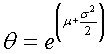

avec : μ et σ les paramètres de la loi log normal qui régit St

Nous procéderons donc par l'estimation de $log(ϴ)$.

- Nous commençons par le calcul des $log(S_t)$, leur moyenne $\overline{log(S_t)} = \overline{Y} = \frac{\Sigma{log(S_t)}}{|Lookback|}$ et leur écart-type $S = \sigma{log(S_t)}$. $|Lookback|$ le nombre d'élement dans la liste Lookback.
- Ensuite nous utilisons la fonction numba_ppf afin de calculer la valeur critique de l'interval de confiance suivant la loi de Student à deux paramètres : **un % de confiance** et **un degré de liberté** = au nombres d'élements de la liste Lookback.
- L'interval de confiance est défini comme suit :

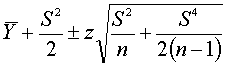

$n$ : degré de liberté = $|Lookback|$

- Après calcul, nous passons ensuite à l'exponentiel pour récupérer l'intervalle de confiance de ϴ.

- Ensuite nous récupérons $K_u$ et $K_d$ de la manière suivante :

$K_u$ = $max($$e^{\operatorname{BorneSup}(I)}$$,1)$
$K_d$ = $min($$e^{\operatorname{BorneInf}(I)}$$,1)$

avec $I$ = L'interval de confiance.

---

In [ ]:
@njit(fastmath = True)
def Teta(prices, ic, st, t, K, T):
  Supp_Ku = np.ones(T, dtype = np.float64)
  Supp_Kd = np.ones(T, dtype = np.float64)
  for i in range(T):
    input = prices[i:]
    today = input[-1]
    logged_prices = np.log(input)
    n = len(logged_prices)
    m = moy(logged_prices)
    s = et(logged_prices, m)
    mu = m + (s**2)/2
    z = numba_ppf(n, (1+ic)/2)
    err = (s**2/n) + (s**4/(2*(n-1)))
    interval = z * np.sqrt(err)
    Ku = np.exp(mu + interval) / today
    Kd = np.exp(mu - interval)/ today

    Supp_Kd[i] = min(max(Kd,0),1)
    Supp_Ku[i] = max(Ku,1)
  qte: float = 0
  V0 : float = 0
  if t == 0:
    V0 = g(int(t), int(T), float(K), Supp_Ku, Supp_Kd, float(st))
    qte = (g(int(t+1), int(T), float(K), Supp_Ku, Supp_Kd, float(Supp_Ku[t]*st)) - g(int(t+1), int(T), float(K), Supp_Ku, Supp_Kd, float(Supp_Kd[t]*st))) / ((Supp_Ku[t] - Supp_Kd[t])*st)
  else:
    qte = (g(int(t+1), int(T), float(K), Supp_Ku, Supp_Kd, float(Supp_Ku[t]*st)) - g(int(t+1), int(T), float(K), Supp_Ku, Supp_Kd, float(Supp_Kd[t]*st))) / ((Supp_Ku[t] - Supp_Kd[t])*st)

  return qte, V0

In [ ]:
@njit(fastmath = True)
def Sureplication(window, ic: float, n_train: int, T: int, K: float):
  for i in nb.prange(n_train, len(window)):
    train = window[:i]
    qt, V0_window = Teta(train, ic, window[i], i - n_train, K, T)
    if i==n_train:
      V0 = V0_window
      Vt_: float = V0_window + qt*(window[i] - window[i-1])
      S0 = window[i]
    elif i==len(window) - 1:
      payoff: float = max(window[i] - K, 0)
      Payoff = payoff 
      Vt_ = Vt_ + qt*(window[i] - window[i-1])
      VT = Vt_ 
    else:
      Vt_ = Vt_ + qt*(window[i] - window[i-1])
  VT = Vt_
  return VT, Payoff, V0, S0

In [ ]:
#@njit(fastmath = True, cache = True)
def ratio_sureplication(L, P):
  n = len(L)
  pas = 1/n
  s=0
  for i in nb.prange(n):
    if L[i] >= P[i]:
      s+=pas

  return s

---

Les deux mesures suivantes de la volatilité seront utilisés dans le 2e modèle. L'Ecart-type de **Yang Zhang est réputé être 14x plus efficient** que l'écart type normal entre les prix de Close.

---


In [ ]:
@njit(fastmath = True, cache = True)
def Sigma_Rogers_Satchell(prices, highs, lows, opens):
  s = 0
  h_c_h_o_l_c_l_o = np.log(highs/prices) * np.log(highs/opens) + np.log(lows/prices) * np.log(lows/opens)
  return moy(h_c_h_o_l_c_l_o)


In [ ]:
@njit(fastmath = True, cache = True)
def Sigma_Yang_Zhang(prices, highs, lows, opens):
  ct1 = prices[:-1]
  ot1 = np.roll(opens, -1)[:-1]
  moy_ot1_ct1 = moy(np.log(ot1/ct1))
  Sigma_open = moy((np.log(ot1/ct1) - moy_ot1_ct1)**2)
  ot = opens
  ct = prices
  moy_ct_ot = moy(np.log(ct/ot))
  Sigma_close = moy((np.log(ct/ot) - moy_ct_ot)**2)
  k = 0.34/(1.34+((len(prices)+1)/(len(prices)-1)))
  Sigma_rogers_satchell = Sigma_Rogers_Satchell(prices, highs, lows, opens)
  Sigma_Yang_Zhang = (Sigma_open + k*Sigma_close + (1-k)*Sigma_rogers_satchell)**(1/2)
  return Sigma_Yang_Zhang


---


Nous définissons ici notre fonction **BackTestSimulation** qui permet de backtester la stratégie sur une période donnée.

Elle sera ensuite utiliser intensivement par notre optimisateur.

---

In [ ]:
@njit(fastmath = True)
def BackTestSimulation(data, ic: float, n_train: int, T: int):
  V0 = np.zeros(len(data) - n_train - T, dtype = np.float64)
  S0 = np.zeros(len(data) - n_train - T, dtype = np.float64)
  Payoff = np.zeros(len(data) - n_train - T, dtype = np.float64)
  VT = np.zeros(len(data) - n_train - T, dtype = np.float64)
  for j in nb.prange(len(data) - n_train - T):
    window = prices[j:j+n_train+T]
    K: float = moy(window[n_train:n_train+T])
    VT[j], Payoff[j], V0[j], S0[j] = Sureplication(window, ic, n_train, T, K)
  return VT, Payoff, V0, S0

Test de la fonction avec un **lookback de 11 jours** et des Calls de **maturité 10 jours** avec un **intervalle de confiance de 99%**

In [ ]:
n_train = 11 #durée du lookback
T = 10 #équivalent à la maturité de l'option
ic = 0.99 #confiance en %


Réalisation d'un BackTest de la stratégie de **Janvier 2022 à Janvier 2023**, execution de la stratégie chaque jour, environ **5800 tests**.

In [ ]:
VT, Payoff, V0, S0 = BackTestSimulation(prices, ic, n_train, T)

In [ ]:
A = VT - Payoff
print("Max gain journalier : ", np.round(max(A),2))
print("Max perte journalière : ", np.round(min(A),2))
print("Moyenne des excédants de sureplication : ", np.round(moy(A),2))
print("Moyenne des sous réplications : ",np.round(abs(moy(A[A<0])),2))
print("Ratio de sureplication ", np.round(ratio_sureplication(VT, Payoff)*100,2), "%.")
print("Moyenne du prix de l'option sur le prix du soujacent ", np.round(100*np.mean(V0/S0),2), "%.")
print("Excedant total de sureplication sur la totalité de la durée du backtest : ", np.round(somme(VT) - somme(Payoff),2))


Max gain journalier :  1012.97
Max perte journalière :  -309.34
Moyenne des excédants de sureplication :  144.1
Moyenne des sous réplications :  46.18
Ratio de sureplication  96.72 %.
Moyenne du prix de l'option sur le prix du soujacent  2.46 %.
Excedant total de sureplication sur la totalité de la durée du backtest :  844137.37




---


Le graphe ci dessous représente les résultats du **BackTest jour par jour**, vous pouvez zoomer, choisir un intervalle précis de jour à regarder, l'air entre les courbes <font color='red'>**VT**</font> (Valeur du ptf à maturité) et le <font color='blue'>**Payoff**</font> est en <font color='green'>**vert**</font> quand la sureplication est bonne et en <font color='red'>**rouge**</font> dans le cas inverse.



---



In [ ]:
Valeur_portefeuille = VT
Payoff = Payoff

difference = [Valeur_portefeuille[i] - Payoff[i] for i in range(len(Valeur_portefeuille))]

candle_data = []
for i in range(len(Valeur_portefeuille)):
    if difference[i] > 0:
        candle_data.append(dict(x=i, open=Payoff[i], high=Payoff[i], low=Valeur_portefeuille[i], close=Valeur_portefeuille[i]))
    elif difference[i] < 0:
        candle_data.append(dict(x=i, open=Payoff[i], high=Payoff[i], low=Valeur_portefeuille[i], close=Valeur_portefeuille[i]))
    else:
        candle_data.append(dict(x=i, open=Payoff[i], high=Payoff[i], low=Valeur_portefeuille[i], close=Valeur_portefeuille[i]))
fig = go.Figure(data=[go.Scatter(x=np.arange(0,len(Valeur_portefeuille)), y=Valeur_portefeuille, name='Valeur portefeuille en T',
                                 line=dict(color='#339933'), marker=dict(color='#339933')),
                      go.Scatter(x=np.arange(0,len(Valeur_portefeuille)), y=Payoff, name='Payoff en T',
                                 line=dict(color='#9933CC'), marker=dict(color='#9933CC')),
                      go.Candlestick(x=np.arange(0,len(Valeur_portefeuille)), open=list(map(lambda x: x['open'], candle_data)), high=list(map(lambda x: x['high'], candle_data)), low=list(map(lambda x: x['low'], candle_data)), close=list(map(lambda x: x['close'], candle_data)), increasing_line_color= '#90EE90', decreasing_line_color= 'red', name = 'Différence VT - Payoff')])
fig.update_layout(title='Valeur portefeuille en T vs Payoff en T',
                  xaxis_title='Temps (jours)',
                  yaxis_title='Value (Euro)',
                  paper_bgcolor='rgba(0,0,0,0)',
                  plot_bgcolor='rgba(0,0,0,0)',
                  xaxis=dict(showgrid=False),
                  yaxis=dict(showgrid=False))



---


Le graphe ci dessous représente la différence <font color='red'>**VT**</font> - <font color='blue'>**Payoff**</font>.



---



In [ ]:
Valeur_portefeuille = VT
Payoff = Payoff
Diff = [Valeur_portefeuille[i] - Payoff[i] for i in range(len(Payoff))]
mean_diff = moy(np.array(Diff, dtype = np.float64))
min_diff = min(np.array(Diff, dtype = np.float64))
max_diff = max(np.array(Diff, dtype = np.float64))
mean_Diff = [mean_diff for i in range(len(Payoff))]
min_Diff = [min_diff for i in range(len(Payoff))]
max_Diff = [max_diff for i in range(len(Payoff))]

fig = go.Figure(data=[go.Scatter(x=np.arange(0,len(Valeur_portefeuille),1), y=Diff, name='VT - payoff en T',
                                 line=dict(color='#00BFFF'), marker=dict(color='#00BFFF')),
                      go.Scatter(x=np.arange(0,len(Valeur_portefeuille),1), y=mean_Diff, name='Moyenne VT - Payoff',
                                 line=dict(color='#1d0ed1'), marker=dict(color='#1d0ed1')),
                      go.Scatter(x=np.arange(0,len(Valeur_portefeuille),1), y=max_Diff, name='Max VT - Payoff',
                                 line=dict(color='green'), marker=dict(color='green')),
                      go.Scatter(x=np.arange(0,len(Valeur_portefeuille),1), y=min_Diff, name='Min VT - Payoff',
                                 line=dict(color='red'), marker=dict(color='red'))])

fig.update_layout(title='VT - payoff en T',
                  xaxis_title='Temps (jours)',
                  yaxis_title='Value (Euro)',
                  paper_bgcolor='rgba(0,0,0,0)',
                  plot_bgcolor='rgba(0,0,0,0)',
                  xaxis=dict(showgrid=False),
                  yaxis=dict(showgrid=False))
fig.update_layout(font=dict(family='Courier New, monospace', size=14))

fig.update_layout(xaxis_title_font_color='#636363',
                  yaxis_title_font_color='#636363',
                  xaxis_title_font=dict(family='Verdana', size=14, color='#636363'),
                  yaxis_title_font=dict(family='Verdana', size=14, color='#636363'),
                  title_x = 0.5)
fig.show()

---


Nous remarquons que la suréplication est bonne dans la majorité des cas, mais ceci n'est pas suffisant, l'un des moyens insidieux d'assurer une bonne sureplication est de simplement augmenter le $V_0 = g(0,S_0)$.

Autrement dit, choisir des $K_u$ et $K_d$ très conservateurs $\Leftrightarrow$ $\text{Supp}_{F_t}(S_{t+1})$ très large $\Rightarrow$ $V_0$ élevé.

Le soucis est que nous sommes dans un marché, si $V_0$ est élevé pratiquement, nous ne trouverons pas d'acheteur.

Ci-dessous les prix des options à l'instant $t = 0$, $V_0$ :

---


In [ ]:
fig = go.Figure(data=[go.Scatter(x=np.arange(0,len(Valeur_portefeuille),1), y=V0, name='Prix V0',
                                 line=dict(color='#339933'), marker=dict(color='#339933'))])

fig.update_layout(title='Prix V0',
                  xaxis_title='Temps (jours)',
                  yaxis_title='Value (Euro)',
                  paper_bgcolor='rgba(0,0,0,0)',
                  plot_bgcolor='rgba(0,0,0,0)',
                  xaxis=dict(showgrid=False),
                  yaxis=dict(showgrid=False))
fig.update_layout(font=dict(family='Courier New, monospace', size=14))


fig.update_traces(line=dict(color='#00BFFF', width=2))

fig.update_layout(xaxis_title_font_color='#636363',
                  yaxis_title_font_color='#636363',
                  xaxis_title_font=dict(family='Verdana', size=14, color='#636363'),
                  yaxis_title_font=dict(family='Verdana', size=14, color='#636363'),
                  title_x = 0.5)
fig.show()



---


Un métrique qui permetterait de mesurer si l'option est cher peut être :    


*   Selon le marché, nous pourrions imaginer : $\frac{V_0}{S_0}$
*   Selon l'acheteur de l'option : $\frac{V_0}{\text{Payoff}}$
*   Selon le vendeur de l'option (nous) : $\frac{V_0}{V_T}$.

Nous choisissons dans un premier temps la mesure par rapport au marché, le graphe ci dessous représente le ratio : $\frac{V_0}{S_0}$


---



In [ ]:
Valeur_portefeuille = VT
Payoff =  Payoff
Diff = [Valeur_portefeuille[i] - Payoff[i] for i in range(len(Payoff))]
V0S0 = np.divide(V0, S0)
mean_v0s0 = moy(V0S0)
mean_V0S0 = [mean_v0s0 for i in range(len(Payoff))]
fig = go.Figure(data=[go.Scatter(x=np.arange(0,len(Valeur_portefeuille),1), y=V0S0, name='V0/S0',
                                 line=dict(color='#00BFFF'), marker=dict(color='#00BFFF')),
                      go.Scatter(x=np.arange(0,len(Valeur_portefeuille),1), y=mean_V0S0, name='Moyenne V0/S0',
                                 line=dict(color='#1d0ed1'), marker=dict(color='#1d0ed1'))])

fig.update_layout(title='V0/S0',
                  xaxis_title='Temps (jours)',
                  yaxis_title='Value (Euro)',
                  paper_bgcolor='rgba(0,0,0,0)',
                  plot_bgcolor='rgba(0,0,0,0)',
                  xaxis=dict(showgrid=False),
                  yaxis=dict(showgrid=False))
fig.update_layout(font=dict(family='Courier New, monospace', size=14))


fig.update_layout(xaxis_title_font_color='#636363',
                  yaxis_title_font_color='#636363',
                  xaxis_title_font=dict(family='Verdana', size=14, color='#636363'),
                  yaxis_title_font=dict(family='Verdana', size=14, color='#636363'),
                  title_x = 0.5)
fig.show()




---


Nous pourrons comparer le prix des options pricés par l'intermédiaire de ce modèle aux prix de Black & Scholes comme référence.

Ci-après l'algorithme de calcul du modèle de **Black & Scholes** en fonction de la volatilité, le prix du soujacent, le Strike, le taux sans risque = 0 dans notre cas et la maturité T.

---



In [ ]:
def bs_price(option_type, sigma, s, k, r, T):
    sigma = float(sigma)
    d1 = (np.log(s / k) + (r + sigma ** 2 * 0.5) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'c':
        price = np.exp(-r*T) * (s * np.exp((r)*T) * stats.norm.cdf(d1) - k *  stats.norm.cdf(d2))
        return price
    elif option_type == 'p':
        price = np.exp(-r*T) * (k * stats.norm.cdf(-d2) - s * np.exp((r)*T) *  stats.norm.cdf(-d1))
        return price
def implied_vol(option_type, option_price, s, k, r, T):
    precision = 0.00001
    upper_vol = 500.0
    max_vol = 500.0
    min_vol = 0.0001
    lower_vol = 0.0001
    iteration = 0

    while 1:
        iteration +=1
        mid_vol = (upper_vol + lower_vol)/2.0
        price = bs_price(option_type, mid_vol, s, k, r, T)
        if option_type == 'c':

            lower_price = bs_price(option_type, lower_vol, s, k, r, T)
            if (lower_price - option_price) * (price - option_price) > 0:
                lower_vol = mid_vol
            else:
                upper_vol = mid_vol
            if abs(price - option_price) < precision: break 
            if mid_vol > max_vol - 5 :
                mid_vol = 0.000001
                break

        elif option_type == 'p':
            upper_price = bs_price(option_type, upper_vol, s, k, r, T)

            if (upper_price - option_price) * (price - option_price) > 0:
                upper_vol = mid_vol
            else:
                lower_vol = mid_vol
            if abs(price - option_price) < precision: break 
            if iteration > 50: break

    return mid_vol




---


Le code ci-dessous prend l'exemple d'une journée du Backtest et calcul V0, P0_bs(prix Black & Scholes), VT : la valeur du portefeuille à maturité et le Payoff.



---



In [ ]:
t0 = 2990
n_train = 11
T = 10
pct_conf = 0.95
window = prices[t0:t0+n_train+T]
window_change = pd.Series(window).pct_change()
Sigma = window_change.std() * np.sqrt(255)
min_strike = mediane(window[n_train:n_train+T]) * 0.7
max_strike = mediane(window[n_train:n_train+T]) * 1.3
strikes = np.linspace(min_strike, max_strike, 500)
VTs = np.zeros(len(strikes), dtype = np.float64)
Payoffs = np.zeros(len(strikes), dtype = np.float64)
V0s = np.zeros(len(strikes), dtype = np.float64)
P0_bs = np.zeros(len(strikes), dtype = np.float64)
S0s = np.zeros(len(strikes), dtype = np.float64)
for i in range(len(strikes)):
  VTs[i], Payoffs[i], V0s[i], S0s[i] = Sureplication(window, pct_conf, n_train, T, strikes[i])
  P0_bs[i] = bs_price('c', Sigma, S0s[0], strikes[i], 0, T/255)



---


*   **En bleu foncé** : Le prix V0 pricé avec le modèle ci-dessus.
*   **En bleu clair** : Le prix P0_bs pricé par le modèle de Black & Scholes.


*   **En rouge** : Le Payoff à maturité.
*   **En vert** : VT la valeur du portefeuille à maturité.


Nous remarquons que le prix **V0 est toujours inférieur au prix Black & Sholes **tout en surépliquant **avec un gain de 40 euro en moyenne.**

---



In [ ]:
fig = go.Figure(data=[go.Scatter(x=strikes, y=V0s, name='V0 % Strike',
                                 line=dict(color='#00008B'), marker=dict(color='#00008B')),
                      go.Scatter(x=strikes, y=P0_bs, name='P0_bs % Strike',
                                 line=dict(color='#00BFFF'), marker=dict(color='#00BFFF')),
                      go.Scatter(x=strikes, y=Payoffs, name='Payoff % Strike',
                                 line=dict(color='red'), marker=dict(color='red')),
                      go.Scatter(x=strikes, y=VTs, name='VT % Strike',
                                 line=dict(color='green'), marker=dict(color='green'))])

fig.update_layout(title='V0 % Strike',
                  xaxis_title='Strike (€)',
                  yaxis_title='Valeur (€)',
                  paper_bgcolor='rgba(0,0,0,0)',
                  plot_bgcolor='rgba(0,0,0,0)',
                  xaxis=dict(showgrid=False),
                  yaxis=dict(showgrid=False))
fig.update_layout(font=dict(family='Courier New, monospace', size=14))

fig.update_layout(xaxis_title_font_color='#636363',
                  yaxis_title_font_color='#636363',
                  xaxis_title_font=dict(family='Verdana', size=14, color='#636363'),
                  yaxis_title_font=dict(family='Verdana', size=14, color='#636363'),
                  title_x = 0.5)
fig.show()



---


Le code ci-dessous calcul la **volatilité implicite** pour le prix V0 calculé par notre modèle en utilisant une méthode numérique (dichotomie) avec la fonction de Black & Scholes.

Le but est de tracer un **smile de volatilité**, si le modèle le permet biensur.

 Temps d'éxecution : **4s**.

---



In [ ]:
t0 = 1127
n_train = 11
T = 10
pct_conf = 0.95
window = prices[t0:t0+n_train+T]
window_change = pd.Series(window).pct_change()
Sigma = window_change.std() * np.sqrt(255)
min_strike = mediane(window[n_train:n_train+T]) * 0.7
max_strike = mediane(window[n_train:n_train+T]) * 1.3
strikes = np.linspace(min_strike, max_strike, 500)
VTs = np.zeros(len(strikes), dtype = np.float64)
Payoffs = np.zeros(len(strikes), dtype = np.float64)
V0s = np.zeros(len(strikes), dtype = np.float64)
P0_bs = np.zeros(len(strikes), dtype = np.float64)
S0s = np.zeros(len(strikes), dtype = np.float64)
IMP_VOL = np.zeros(len(strikes), dtype = np.float64)
for i in range(len(strikes)):
  VTs[i], Payoffs[i], V0s[i], S0s[i] = Sureplication(window, pct_conf, n_train, T, strikes[i])
  IMP_VOL[i] = implied_vol('c', V0s[i], S0s[0], strikes[i], 0, T/255) 
IMP_VOL = pd.Series(IMP_VOL).rolling(150).mean().to_numpy()

In [ ]:
fig = go.Figure(data=[go.Scatter(x=strikes, y=IMP_VOL[120:], name='Impl Vol % Strike',
                                 line=dict(color='#00BFFF'), marker=dict(color='#00BFFF'))])

fig.update_layout(title='Impl Vol % Strike',
                  xaxis_title='Volatilité',
                  yaxis_title='Strike',
                  paper_bgcolor='rgba(0,0,0,0)',
                  plot_bgcolor='rgba(0,0,0,0)',
                  xaxis=dict(showgrid=False),
                  yaxis=dict(showgrid=False))
fig.update_layout(font=dict(family='Courier New, monospace', size=14))

fig.update_layout(xaxis_title_font_color='#636363',
                  yaxis_title_font_color='#636363',
                  xaxis_title_font=dict(family='Verdana', size=14, color='#636363'),
                  yaxis_title_font=dict(family='Verdana', size=14, color='#636363'),
                  title_x = 0.5)
fig.show()



---


Afin de paufiner le modèle, nous souhaitons optimiser une fonction ou des fonctions objectifs (définis ci-après) tout en jouant sur les paramètres :


*   **IC** : % de confiance.
*   **TS** : Train size ou le nombre de jour de lookback.


Nous commençons donc par calculer les résultats des backtests pour une plage de combinaisons de couples (IC, TS).

---



In [ ]:
@njit(fastmath = True)
def Optimizer(prices, IC, TS, n_test):
  output = List()
  for i in nb.prange(len(IC)):
    for j in nb.prange(len(TS)):
      output.append(BackTestSimulation(prices, IC[i], TS[j], n_test))
  return output



---

Nous initialisons une liste de $%$ de confiance dans l'intervalle $[0.01,1[$ avec des pas de $0.05$.
Ensuite, nos initialisons une liste de lookback periods dans l'intervalle $[Maturité+1, 60]$ avec des pas de $1$ jour.

Nous recommendons de garder run_Optimizer = $False$, l'optimisation prend $15h$ à $20h$, un run a été réalisé le fichier généré $(output_calculation.npy)$ fait $100$ à $200$ Mo et est stocké sur Github. Ce fichier est utilisé directement pour l'affichage des résultats.


---



In [ ]:
run_Optimizer = False
if not os.path.exists('output_calculation.npy'):
  !wget https://media.githubusercontent.com/media/ElAm1ne/March--Fi-2/master/output_calculation.npy
if not os.path.exists('output_calculation2.npy'):
  !wget https://media.githubusercontent.com/media/ElAm1ne/March--Fi-2/master/output_calculation2.npy
if (not os.path.exists('output_calculation.npy')) and run_Optimizer == True:#Eviter de changer run_Optimize == False => Risque de prendre des heures (15 à 20h)
  IC = np.arange(0.01,1,0.05, dtype = np.float64)
  Lookback_days = np.arange(T+1, 60,1, dtype = np.int64)
  output = Optimizer(prices, IC, Lookback_days, T)
  otp = []
  for i in range(len(output)):
    otp.append(output[i])
  saved = np.array(otp, dtype = object)
  np.save('output_calculation.npy', saved)

--2023-01-04 03:26:31--  https://media.githubusercontent.com/media/ElAm1ne/March--Fi-2/master/output_calculation.npy
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 148779310 (142M) [application/octet-stream]
Saving to: ‘output_calculation.npy’

output_calculation. 100%[===================>] 141.89M   279MB/s    in 0.5s    

2023-01-04 03:26:38 (279 MB/s) - ‘output_calculation.npy’ saved [148779310/148779310]

--2023-01-04 03:26:38--  https://media.githubusercontent.com/media/ElAm1ne/March--Fi-2/master/output_calculation2.npy
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.108.133|:443... connec

In [ ]:
loaded = np.load('output_calculation.npy', allow_pickle = True)



---


Nous proposons plusieurs fonctions objectives :
- Une premère fonction objectif qui relie l'exedant de suréplication au payoff comme un rendement de suréplication et le compare en dénominateur au ratio entre le prix de l'option sur le prix du sous jacent comme suit : \begin{equation}f_1(V_T, V_0, PO, S0) = \frac{\frac{\sum_{VT} - \sum_{PO}}{\sum_{PO}}}{\sum_{\frac{V0}{S0}}}\end{equation}

- Une deuxième fonction qui est le ratio de suréplication, l'opérateur |$V_T$| signifie le nombre d'élement de l'ensemble $V_T$ : \begin{equation}
f_2(V_T) = \frac{\sum_{x \in V_T, x > 0}}{|V_T|}
\end{equation}.
- Une troisième fonction qui permet de calculer la consistance du modèle en calculant la moyenne sur l'écart type : \begin{equation}
f_3(V_T) = \frac{\overline{V_T - PO}}{\sigma_{V_T - PO}}
\end{equation}
- Une quatrieme fonction qui permet de calculer l'excedant total de suréplication du Backtest : \begin{equation}
f_4(V_T, PO) = \sum_{x \in V_T} x - \sum_{y \in PO} y
\end{equation}
- Une dernière fonction qui permet de mesurer la cherté de l'option, l'opérateur |$V_0$| signifie le nombre d'élement de l'ensemble $V_0$ : \begin{equation}
f_5(V_0, S_0) = \frac{\sum_{x,y \in V_0, S_0}}{|V_0|}
\end{equation}


---






In [ ]:
IC = np.arange(0.01,1,0.05, dtype = np.float64)
Lookback_days = np.arange(T+1, 60,1, dtype = np.int64)
obj = []
lbd = []
ic = []
obj2 = []
obj3 = []
obj4 = []
obj5 = []
for i in range(len(loaded)):
  VT, Payoff, V0, S0 = loaded[i]
  V0S0 = np.divide(V0,S0)
  sum_VT = np.sum(VT)
  sum_PO = np.sum(Payoff)
  sum_V0 = np.sum(V0)
  sum_S0 = np.sum(S0)
  sum_V0S0 = np.sum(V0S0)
  ratio_sureplique = ratio_sureplication(VT, Payoff)
  Diff_VT_PO = VT - Payoff
  m1 = np.mean(Diff_VT_PO)
  ic.append(IC[i//len(Lookback_days)])
  lbd.append(Lookback_days[i%len(Lookback_days)])
  obj.append(((sum_VT - sum_PO)/sum_PO)/(sum_V0S0))
  obj2.append(ratio_sureplique)
  obj3.append(m1/np.std(Diff_VT_PO))
  obj4.append(np.sum(Diff_VT_PO))
  obj5.append(np.mean(V0S0))

ic = np.array(ic, dtype = np.float64)
lbd = np.array(lbd, dtype = np.float64)
obj = np.array(obj, dtype = np.float64)
obj2 = np.array(obj2, dtype = np.float64)
obj3 = np.array(obj3, dtype = np.float64)
obj4 = np.array(obj4, dtype = np.float64)
obj5 = np.array(obj5, dtype = np.float64)

x = ic
y = lbd
z_obj_1 = obj
z_obj_2 = obj2
z_obj_3 = obj3
z_obj_4 = obj4
z_obj_5 = obj5

precision = 150

In [ ]:
results_ = pd.DataFrame({'IC': ic, 'LBD': lbd,'VT - PO / PO / V0/S0': obj,'Ratio Sureplication': obj2,'Moyenne/EcartType': obj3 ,'Somme VT - Payoff': obj4 ,'V0/S0': obj5 })



---


Voici les résultats de l'optimisation, en fonction des différents paramètres et fonction objectif.

Temps d'éxecution : **30s**.


---



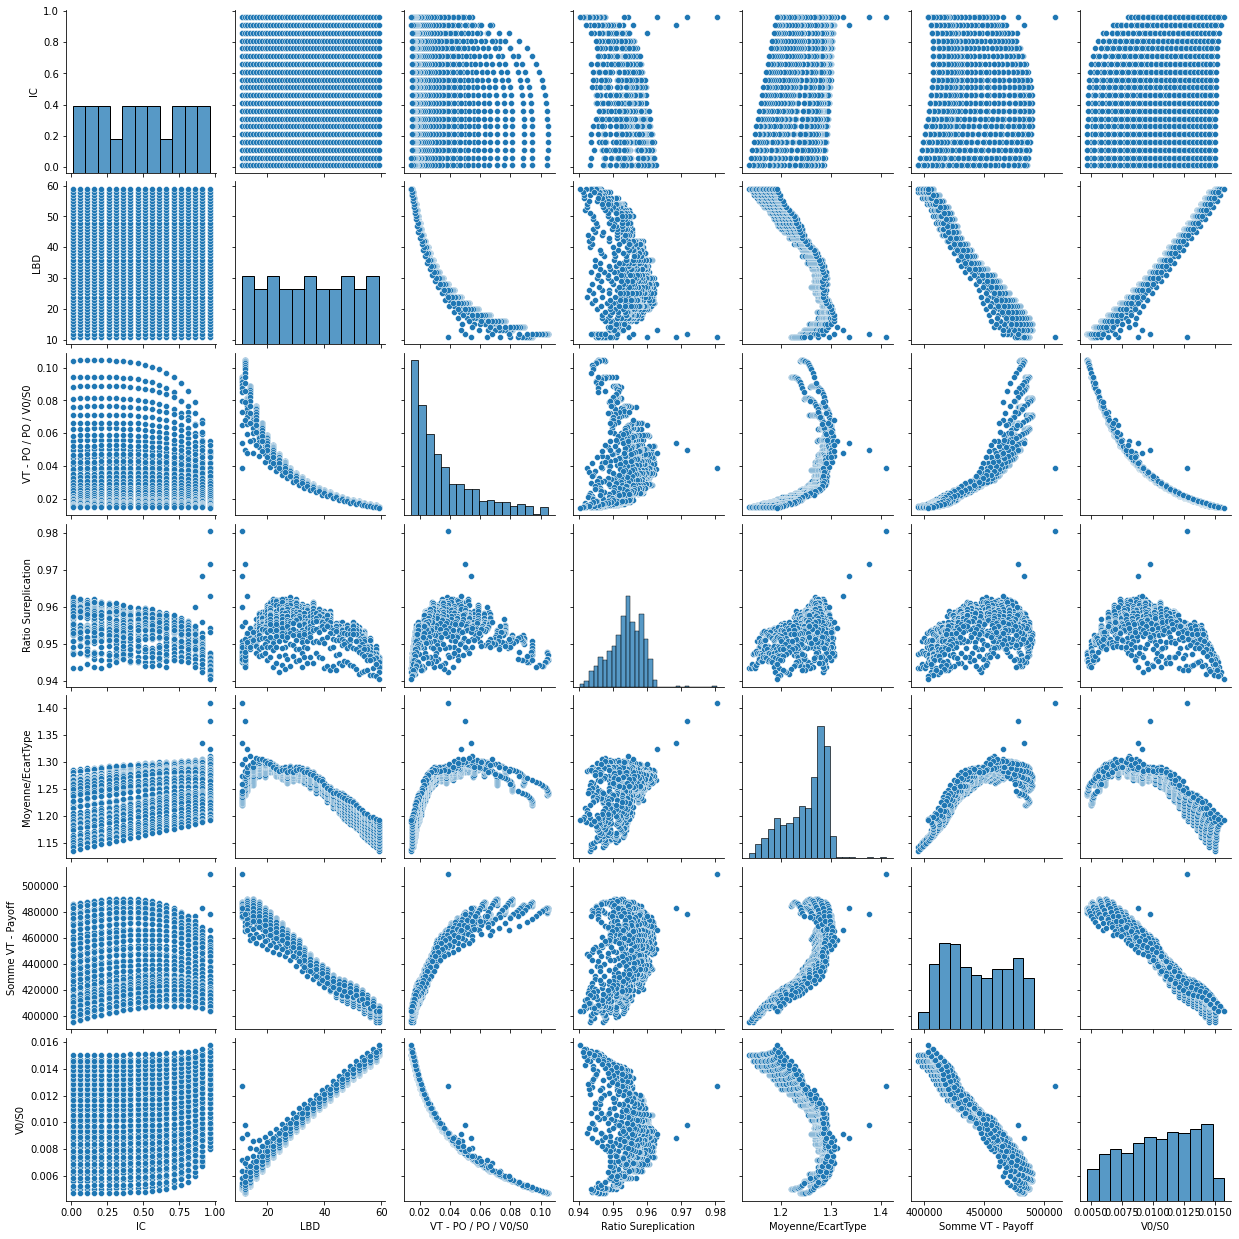

In [ ]:
sns.pairplot(results_)



---

Nous remarquons qu'un intervalle de confiance plus large est généralement plus intéressent, ceci nous permet de se couvrir, cependant, ce dernier augmente le prix de l'option (le ratio $\frac{V_0}{S_0}$).

Nous remarquons aussi que les résultats du modèle se dégrade plus notre lookback est élevé. Avec un maximum global de taux de sureplication pour la valeur $T+1 = 11 jours$ et un maximum local à $28 jours$.

Dans la suite, nous nous focalisons uniquement sur un lookback de $11 jours$ et les pourcentages de confiance entre $90$% et $99.99$%, cette plage permet des pourcentages de suréplication supérieur à $95$%.

L'idée est de chercher le couple $(IC, TS)$ qui vérifie les propriétés suivantes : 
- $f_2(IC,TS) > 95$%
- $\min_{IC, TS} f_5$

In [ ]:
loaded = np.load('output_calculation2.npy', allow_pickle = True)

In [ ]:
IC = np.arange(0.9,1,0.0001, dtype = np.float64)
Lookback_days = np.arange(T+1, T+2,1, dtype = np.int64)
obj = []
lbd = []
ic = []
obj2 = []
obj3 = []
obj4 = []
obj5 = []
for i in range(len(loaded)):
  VT, Payoff, V0, S0 = loaded[i]
  V0S0 = np.divide(V0,S0)
  sum_VT = np.sum(VT)
  sum_PO = np.sum(Payoff)
  sum_V0 = np.sum(V0)
  sum_S0 = np.sum(S0)
  sum_V0S0 = np.sum(V0S0)
  ratio_sureplique = ratio_sureplication(VT, Payoff)
  Diff_VT_PO = VT - Payoff
  m1 = np.mean(Diff_VT_PO)
  ic.append(IC[i//len(Lookback_days)])
  lbd.append(Lookback_days[i%len(Lookback_days)])
  obj.append(((sum_VT - sum_PO)/sum_PO)/(sum_V0S0))
  obj2.append(ratio_sureplique)
  obj3.append(m1/np.std(Diff_VT_PO))
  obj4.append(np.sum(Diff_VT_PO))
  obj5.append(np.mean(V0S0))

ic = np.array(ic, dtype = np.float64)
lbd = np.array(lbd, dtype = np.float64)
obj = np.array(obj, dtype = np.float64)
obj2 = np.array(obj2, dtype = np.float64)
obj3 = np.array(obj3, dtype = np.float64)
obj4 = np.array(obj4, dtype = np.float64)
obj5 = np.array(obj5, dtype = np.float64)

In [ ]:
results_ = pd.DataFrame({'IC': ic, 'LBD': lbd,'VT - PO / PO / V0/S0': obj,'Ratio Sureplication': obj2,'Moyenne/EcartType': obj3 ,'Somme VT - Payoff': obj4 ,'V0/S0': obj5 })

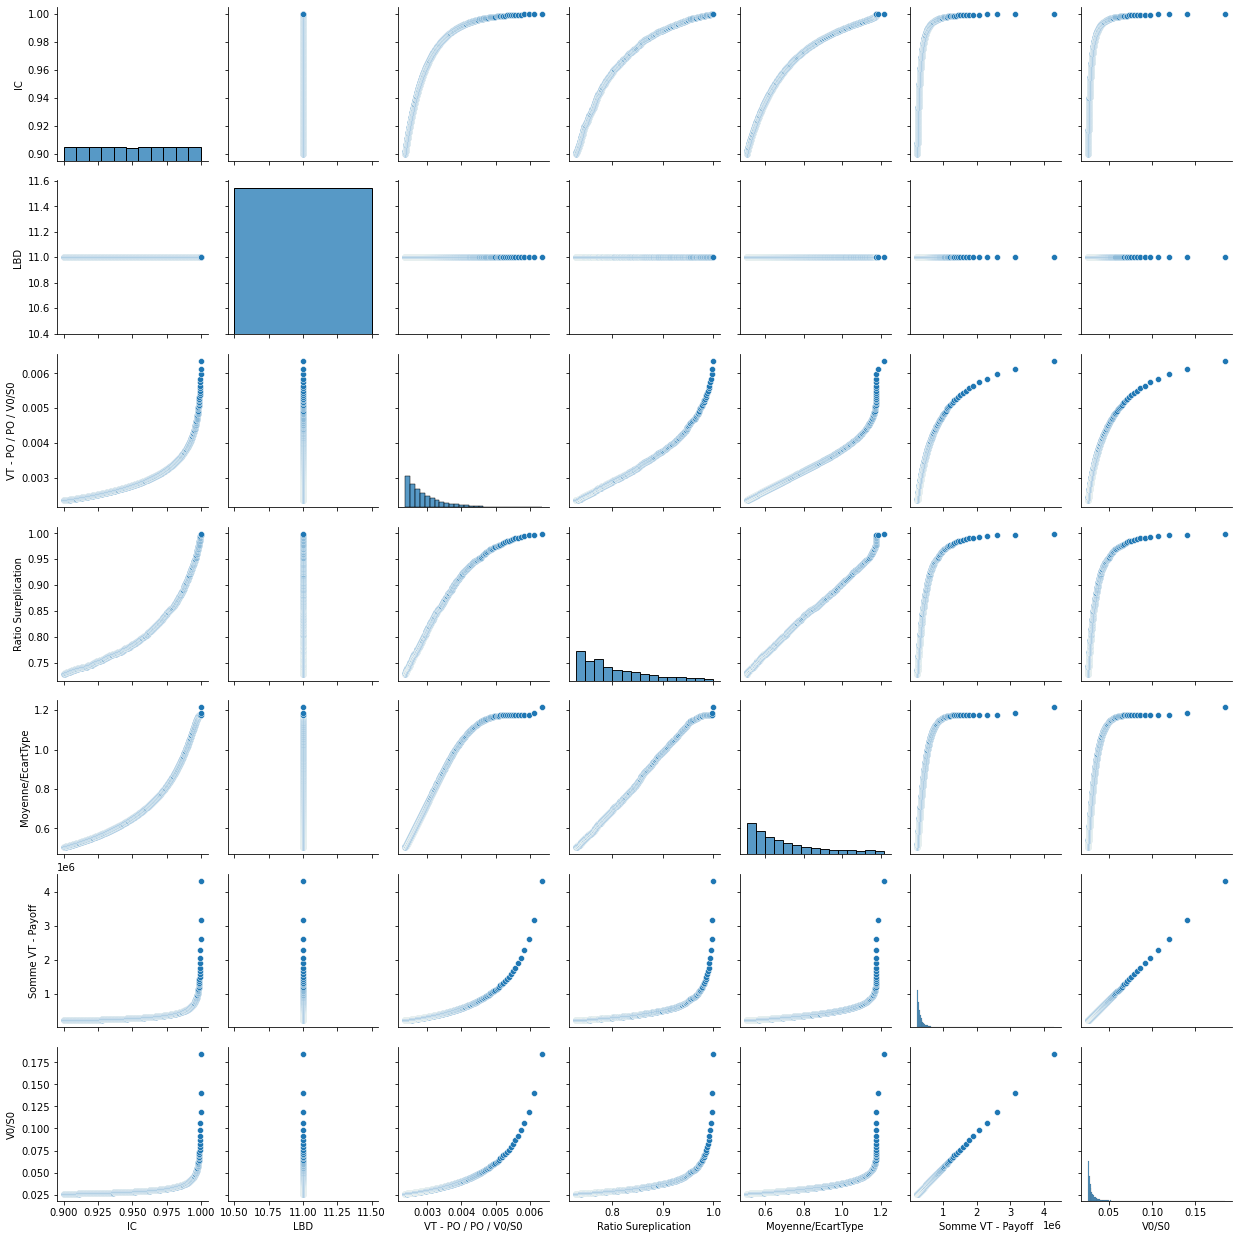

In [ ]:
sns.pairplot(results_)



---

Nous remarquons ci-dessous que le pourcentage de confiance optimal pour **un lookback de 11 jours** avec un **ratio de suréplication à 95%** est **99.589%**

---



In [ ]:
min_V0S0 = math.inf
arg_min = -1
target_sureplication = 0.95
for i in range(len(obj2)):
  if obj2[i] > target_sureplication:
    if obj5[i] < min_V0S0:
      arg_min = i
      min_V0S0 = obj5[i]
print("Le minimum de ratio prix de sureplication est : ", np.round(100*min_V0S0,2), "%.")
print("% de confiance optimal est : ", ic[arg_min])

Le minimum de ratio prix de sureplication est :  4.85 %.
% de confiance optimal est :  0.9958999999999895




---


La partie suivante visualize chacune des fonctions objectif en fonction du Lookback et du pourcentage de confiance.

Au vu de la quantité de données, il est impossible de tracer tous les points sans que Colab crash, nous procédons donc par échantillonage (dédensification) puis par interpolation afin de densifier uniquement dans les points manquants.

---



In [ ]:
loaded = np.load('output_calculation.npy', allow_pickle = True)
IC = np.arange(0.01,1,0.05, dtype = np.float64)
Lookback_days = np.arange(T+1, 60,1, dtype = np.int64)
obj = []
lbd = []
ic = []
obj2 = []
obj3 = []
obj4 = []
obj5 = []
for i in range(len(loaded)):
  VT, Payoff, V0, S0 = loaded[i]
  V0S0 = np.divide(V0,S0)
  sum_VT = np.sum(VT)
  sum_PO = np.sum(Payoff)
  sum_V0 = np.sum(V0)
  sum_S0 = np.sum(S0)
  sum_V0S0 = np.sum(V0S0)
  ratio_sureplique = ratio_sureplication(VT, Payoff)
  Diff_VT_PO = VT - Payoff
  m1 = np.mean(Diff_VT_PO)
  ic.append(IC[i//len(Lookback_days)])
  lbd.append(Lookback_days[i%len(Lookback_days)])
  obj.append(((sum_VT - sum_PO)/sum_PO)/(sum_V0S0))
  obj2.append(ratio_sureplique)
  obj3.append(m1/np.std(Diff_VT_PO))
  obj4.append(np.sum(Diff_VT_PO))
  obj5.append(np.mean(V0S0))

ic = np.array(ic, dtype = np.float64)
lbd = np.array(lbd, dtype = np.float64)
obj = np.array(obj, dtype = np.float64)
obj2 = np.array(obj2, dtype = np.float64)
obj3 = np.array(obj3, dtype = np.float64)
obj4 = np.array(obj4, dtype = np.float64)
obj5 = np.array(obj5, dtype = np.float64)

x = ic
y = lbd
z_obj_1 = obj
z_obj_2 = obj2
z_obj_3 = obj3
z_obj_4 = obj4
z_obj_5 = obj5

precision = 150

\begin{equation}f_1(V_T, V_0, PO, S0) = \frac{\frac{\sum_{VT} - \sum_{PO}}{\sum_{PO}}}{\sum_{\frac{V0}{S0}}}\end{equation}



In [ ]:
xi = np.linspace(x.min(), x.max(), precision)
yi = np.linspace(y.min(), y.max(), precision)
X,Y = np.meshgrid(xi,yi)

In [ ]:
Z_obj_1 = griddata((x,y),z_obj_1,(X,Y), method='cubic')

In [ ]:
fig = go.Figure(go.Surface(x=xi,y=yi,z=Z_obj_1, hidesurface = False))
fig.update_traces(contours_z=dict(show=True, usecolormap=True,highlightcolor="limegreen", project_z=True), 
                  contours_x=dict(show=True, usecolormap=True,highlightcolor="limegreen", project_x=True),
                  contours_y=dict(show=True, usecolormap=True,highlightcolor="limegreen", project_y=True))
fig.update_layout(title='Objective function 1', autosize=True,
                  scene_camera_eye=dict(x=1.87, y=0.88, z=0.64),
                  margin=dict(l=65, r=50, b=65, t=90))
fig.show()

\begin{equation}
f_2(V_T) = \frac{\sum_{x \in V_T, x > 0}}{|V_T|}
\end{equation}.


In [ ]:
Z_obj_2 = griddata((x,y),z_obj_2,(X,Y), method='cubic')

In [ ]:
fig = go.Figure(go.Surface(x=xi,y=yi,z=Z_obj_2, hidesurface = False))
fig.update_traces(contours_z=dict(show=True, usecolormap=True,highlightcolor="limegreen", project_z=True), 
                  contours_x=dict(show=True, usecolormap=True,highlightcolor="limegreen", project_x=True),
                  contours_y=dict(show=True, usecolormap=True,highlightcolor="limegreen", project_y=True))
fig.update_layout(title='Objective function 1', autosize=True,
                  scene_camera_eye=dict(x=1.87, y=0.88, z=0.64),
                  margin=dict(l=65, r=50, b=65, t=90))
fig.show()





---


\begin{equation}
f_3(V_T) = \frac{\overline{V_T - PO}}{\sigma_{V_T - PO}}
\end{equation}


---





In [ ]:
Z_obj_3 = griddata((x,y),z_obj_3,(X,Y), method='cubic')

In [ ]:
fig = go.Figure(go.Surface(x=xi,y=yi,z=Z_obj_3, hidesurface = False))
fig.update_traces(contours_z=dict(show=True, usecolormap=True,highlightcolor="limegreen", project_z=True), 
                  contours_x=dict(show=True, usecolormap=True,highlightcolor="limegreen", project_x=True),
                  contours_y=dict(show=True, usecolormap=True,highlightcolor="limegreen", project_y=True))
fig.update_layout(title='Objective function 1', autosize=True,
                  scene_camera_eye=dict(x=1.87, y=0.88, z=0.64),
                  margin=dict(l=65, r=50, b=65, t=90))
fig.show()

\begin{equation}
f_4(V_T, PO) = \sum_{x \in V_T} x - \sum_{y \in PO} y
\end{equation}



In [ ]:
Z_obj_4 = griddata((x,y),z_obj_4,(X,Y), method='cubic')

In [ ]:
fig = go.Figure(go.Surface(x=xi,y=yi,z=Z_obj_4, hidesurface = False))
fig.update_traces(contours_z=dict(show=True, usecolormap=True,highlightcolor="limegreen", project_z=True), 
                  contours_x=dict(show=True, usecolormap=True,highlightcolor="limegreen", project_x=True),
                  contours_y=dict(show=True, usecolormap=True,highlightcolor="limegreen", project_y=True))
fig.update_layout(title='Objective function 1', autosize=True,
                  scene_camera_eye=dict(x=1.87, y=0.88, z=0.64),
                  margin=dict(l=65, r=50, b=65, t=90))
fig.show()

\begin{equation}
f_5(V_0, S_0) = \frac{\sum_{x,y \in V_0, S_0}}{|V_0|}
\end{equation}



In [ ]:
Z_obj_5 = griddata((x,y),z_obj_5,(X,Y), method='cubic')

In [67]:
fig = go.Figure(go.Surface(x=xi,y=yi,z=Z_obj_5, hidesurface = False))
fig.update_traces(contours_z=dict(show=True, usecolormap=True,highlightcolor="limegreen", project_z=True), 
                  contours_x=dict(show=True, usecolormap=True,highlightcolor="limegreen", project_x=True),
                  contours_y=dict(show=True, usecolormap=True,highlightcolor="limegreen", project_y=True))
fig.update_layout(title='Objective function 1', autosize=True,
                  scene_camera_eye=dict(x=1.87, y=0.88, z=0.64),
                  margin=dict(l=65, r=50, b=65, t=90))
fig.show()



---

**II - Méthode 2 : Utilisation des données d'Open, Close, High, Low pour l'estimation de la volatilité du jour et la convertir en $K_u$ et $K_d$**

---



Dans cette partie, l'idée repose sur l'utilisation de la volatilité estimée par l'équation de Zhang Yang suivante : $\sigma_{Zhang\_Yang} = \sqrt{\sigma_o^2 + k*\sigma_c^2 + (1-k)*\sigma_{RS}^2}$

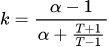


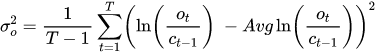

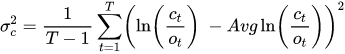

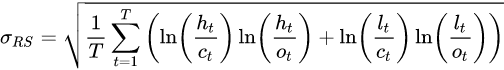

Cette mesure de la volatilité permet d'inclure les variations même en dehors des horaires de trading (entre le close et le open).

$o_t$ : **le prix d'Open**.

$c_t$ : **le prix de Close**.

$h_t$ : **le prix du High**.

$l_t$ : **le prix du Low**.

Nous calculons pour chaque période de train des $K_u$ et $K_d$ suivants les lookbacks, exemple pour le jour $i$, notre lookback sera la période de train - $i$. Plus concrétement : 

Soit les prix ma période de train : [$S_0$, $S_1$, ..., $S_20$]

et ma période de test : [$S_0test$, $St_1test$, ..., $St_9test$]

On définit la période lookback et de laquelle les Ku et Kd seront extraits comme suit :

Pour $S_0test$ : [$S_0$, $S_1$, ..., $S_20$]
Pour $S_1test$ : [$S_1$, ..., $S_20$]
Pour $S_2test$ : [$S_2$, ..., $S_20$]

et ainsi de suite.

Le $K_u$ ou $K_d$ utilisé pour le $St_0$ sera : 

$K_u = max(\frac{\sum_{t=0}^{|Lookback|} \frac{S_{t+1}}{S_t}}{|Lookback|} * \frac{\sigma_{Lookback}}{\sigma_{Train}}, 1)$ ; $|Lookback|$ est le nombre d'élements de la liste Lookback.

$K_d = min(\frac{\sum_{t=0}^{|Lookback|} \frac{S_{t+1}}{S_t}}{|Lookback|} * \frac{\sigma_{Lookback}}{\sigma_{Train}}, 1)$

Le facteur $\frac{\sigma_{Lookback}}{\sigma_{Train}}$ permet de scaler les $K_u$ et $K_d$ en fonction de la volatilité du jour, si la volatilité du Lookback du jour i est > à la volatilité moyenne $=>$ les $K_u$ et $K_d$ refleteront cet aspect proportionnellement à cette mesure.

In [ ]:
@njit(fastmath = True)
def Teta3(prices, highs, lows, opens, st, t, K, T):
  Supp_Ku = np.ones(T, dtype = np.float64)
  Supp_Kd = np.ones(T, dtype = np.float64)
  Sigma_train = Sigma_Yang_Zhang(prices,highs,lows,opens)
  for i in range(T):
    close = prices[i:]
    high = highs[i:]
    low = lows[i:]
    open = opens[i:]
    St1St = (np.roll(close, -1)/close)[:-1]
    St1StKu = St1St[St1St>1]
    St1StKd = St1St[St1St<=1]
    if len(St1StKu) == 0:
      mean_Ku = 1.0
    else:
      mean_Ku = moy(St1StKu)
    if len(St1StKd) == 0:
      mean_Kd = 1.0
    else:
      mean_Kd = moy(St1StKd)

    ratio_sigma =  Sigma_Yang_Zhang(close,high,low,open) / Sigma_train
    Ku = mean_Ku * ratio_sigma
    Kd = mean_Kd * ratio_sigma
    Supp_Ku[i] = max(Ku,1)
    Supp_Kd[i] = min(Kd,1)

  qte: float = 0
  V0 : float = 0

  if t == 0:
    V0 = g(int(t), int(T), float(K), Supp_Ku, Supp_Kd, float(st))
    qte = (g(int(t+1), int(T), float(K), Supp_Ku, Supp_Kd, float(Supp_Ku[t]*st)) - g(int(t+1), int(T), float(K), Supp_Ku, Supp_Kd, float(Supp_Kd[t]*st))) / ((Supp_Ku[t] - Supp_Kd[t])*st)
  else:
    qte = (g(int(t+1), int(T), float(K), Supp_Ku, Supp_Kd, float(Supp_Ku[t]*st)) - g(int(t+1), int(T), float(K), Supp_Ku, Supp_Kd, float(Supp_Kd[t]*st))) / ((Supp_Ku[t] - Supp_Kd[t])*st)

  return qte, V0

In [ ]:
@njit(fastmath = True)
def Sureplication2(window_closes, window_highs,window_lows,window_opens, n_train: int, T: int, K: float):
  for i in nb.prange(n_train, len(window_closes)):
    train_closes = window_closes[:i]
    train_highs = window_highs[:i]
    train_lows = window_lows[:i]
    train_opens = window_opens[:i]
    qt, V0_window = Teta3(train_closes, train_highs, train_lows, train_opens,  window_closes[i], i - n_train, K, T)
    if i==n_train:
      V0 = V0_window
      Vt_: float = V0_window + qt*(window_closes[i] - window_closes[i-1])
      S0 = window_closes[i]
    elif i==len(window_closes) - 1:
      payoff: float = max(window_closes[i] - K, 0)
      Payoff = payoff 
      Vt_ = Vt_ + qt*(window_closes[i] - window_closes[i-1])
      VT = Vt_ 
    else:
      Vt_ = Vt_ + qt*(window_closes[i] - window_closes[i-1])
  return VT, Payoff, V0, S0

In [ ]:
@njit(fastmath = True)
def BackTestSimulation2(data_closes,data_highs,data_lows,data_opens, n_train: int, T: int):
  V0 = np.zeros(len(data_closes) - n_train - T, dtype = np.float64)
  S0 = np.zeros(len(data_closes) - n_train - T, dtype = np.float64)
  Payoff = np.zeros(len(data_closes) - n_train - T, dtype = np.float64)
  VT = np.zeros(len(data_closes) - n_train - T, dtype = np.float64)
  for j in nb.prange(len(data_closes) - n_train - T):
    window_closes = data_closes[j:j+n_train+T]
    window_highs = data_highs[j:j+n_train+T]
    window_lows = data_lows[j:j+n_train+T]
    window_opens = data_opens[j:j+n_train+T]
    K: float = min(window_closes[n_train:n_train+T])
    VT[j], Payoff[j], V0[j], S0[j] = Sureplication2(window_closes, window_highs,window_lows,window_opens, n_train, T, K)
  return VT, Payoff, V0, S0

In [ ]:
n_train = 2000 #durée du lookback
T = 10 #équivalent à la maturité de l'option



---


Temps d'éxecution : **3 minutes**.



---



In [ ]:
VT, Payoff, V0, S0 = BackTestSimulation2(prices, highs, lows, opens, n_train, T)


In [ ]:
A = VT - Payoff
print("Max gain journalier : ", np.round(max(A),2))
print("Max perte journalière : ", np.round(min(A),2))
print("Moyenne des excédants de sureplication : ", np.round(moy(A),2))
print("Moyenne des sous réplications : ",np.round(abs(moy(A[A<0])),2))
print("Ratio de sureplication ", np.round(ratio_sureplication(VT, Payoff)*100,2), "%.")
print("Moyenne du prix de l'option sur le prix du soujacent ", np.round(100*np.mean(V0/S0),2), "%.")
print("Excedant total de sureplication sur la totalité de la durée du backtest : ", np.round(somme(VT) - somme(Payoff),2))


Max gain journalier :  501.48
Max perte journalière :  -435.93
Moyenne des excédants de sureplication :  58.96
Moyenne des sous réplications :  32.74
Ratio de sureplication  91.24 %.
Moyenne du prix de l'option sur le prix du soujacent  3.0 %.
Excedant total de sureplication sur la totalité de la durée du backtest :  228111.52


In [ ]:
Valeur_portefeuille = VT
Payoff = Payoff

difference = [Valeur_portefeuille[i] - Payoff[i] for i in range(len(Valeur_portefeuille))]

candle_data = []
for i in range(len(Valeur_portefeuille)):
    if difference[i] > 0:
        candle_data.append(dict(x=i, open=Payoff[i], high=Payoff[i], low=Valeur_portefeuille[i], close=Valeur_portefeuille[i]))
    elif difference[i] < 0:
        candle_data.append(dict(x=i, open=Payoff[i], high=Payoff[i], low=Valeur_portefeuille[i], close=Valeur_portefeuille[i]))
    else:
        candle_data.append(dict(x=i, open=Payoff[i], high=Payoff[i], low=Valeur_portefeuille[i], close=Valeur_portefeuille[i]))
fig = go.Figure(data=[go.Scatter(x=np.arange(0,len(Valeur_portefeuille)), y=Valeur_portefeuille, name='Valeur portefeuille en T',
                                 line=dict(color='#339933'), marker=dict(color='#339933')),
                      go.Scatter(x=np.arange(0,len(Valeur_portefeuille)), y=Payoff, name='Payoff en T',
                                 line=dict(color='#9933CC'), marker=dict(color='#9933CC')),
                      go.Candlestick(x=np.arange(0,len(Valeur_portefeuille)), open=list(map(lambda x: x['open'], candle_data)), high=list(map(lambda x: x['high'], candle_data)), low=list(map(lambda x: x['low'], candle_data)), close=list(map(lambda x: x['close'], candle_data)), increasing_line_color= '#90EE90', decreasing_line_color= 'red', name = 'Différence VT - Payoff')])
fig.update_layout(title='Valeur portefeuille en T vs Payoff en T',
                  xaxis_title='Temps (jours)',
                  yaxis_title='Value (Euro)',
                  paper_bgcolor='rgba(0,0,0,0)',
                  plot_bgcolor='rgba(0,0,0,0)',
                  xaxis=dict(showgrid=False),
                  yaxis=dict(showgrid=False))

In [ ]:
Valeur_portefeuille = VT
Payoff = Payoff
Diff = [Valeur_portefeuille[i] - Payoff[i] for i in range(len(Payoff))]
mean_diff = moy(np.array(Diff, dtype = np.float64))
min_diff = min(np.array(Diff, dtype = np.float64))
max_diff = max(np.array(Diff, dtype = np.float64))
mean_Diff = [mean_diff for i in range(len(Payoff))]
min_Diff = [min_diff for i in range(len(Payoff))]
max_Diff = [max_diff for i in range(len(Payoff))]

fig = go.Figure(data=[go.Scatter(x=np.arange(0,len(Valeur_portefeuille),1), y=Diff, name='VT - payoff en T',
                                 line=dict(color='#00BFFF'), marker=dict(color='#00BFFF')),
                      go.Scatter(x=np.arange(0,len(Valeur_portefeuille),1), y=mean_Diff, name='Moyenne VT - Payoff',
                                 line=dict(color='#1d0ed1'), marker=dict(color='#1d0ed1')),
                      go.Scatter(x=np.arange(0,len(Valeur_portefeuille),1), y=max_Diff, name='Max VT - Payoff',
                                 line=dict(color='green'), marker=dict(color='green')),
                      go.Scatter(x=np.arange(0,len(Valeur_portefeuille),1), y=min_Diff, name='Min VT - Payoff',
                                 line=dict(color='red'), marker=dict(color='red'))])

fig.update_layout(title='VT - payoff en T',
                  xaxis_title='Temps (jours)',
                  yaxis_title='Value (Euro)',
                  paper_bgcolor='rgba(0,0,0,0)',
                  plot_bgcolor='rgba(0,0,0,0)',
                  xaxis=dict(showgrid=False),
                  yaxis=dict(showgrid=False))
fig.update_layout(font=dict(family='Courier New, monospace', size=14))

fig.update_layout(xaxis_title_font_color='#636363',
                  yaxis_title_font_color='#636363',
                  xaxis_title_font=dict(family='Verdana', size=14, color='#636363'),
                  yaxis_title_font=dict(family='Verdana', size=14, color='#636363'),
                  title_x = 0.5)
fig.show()

In [ ]:
fig = go.Figure(data=[go.Scatter(x=np.arange(0,len(Valeur_portefeuille),1), y=V0, name='Prix V0',
                                 line=dict(color='#339933'), marker=dict(color='#339933'))])

fig.update_layout(title='Prix V0',
                  xaxis_title='Temps (jours)',
                  yaxis_title='Value (Euro)',
                  paper_bgcolor='rgba(0,0,0,0)',
                  plot_bgcolor='rgba(0,0,0,0)',
                  xaxis=dict(showgrid=False),
                  yaxis=dict(showgrid=False))
fig.update_layout(font=dict(family='Courier New, monospace', size=14))


fig.update_traces(line=dict(color='#00BFFF', width=2))

fig.update_layout(xaxis_title_font_color='#636363',
                  yaxis_title_font_color='#636363',
                  xaxis_title_font=dict(family='Verdana', size=14, color='#636363'),
                  yaxis_title_font=dict(family='Verdana', size=14, color='#636363'),
                  title_x = 0.5)
fig.show()

In [ ]:
Valeur_portefeuille = VT
Payoff =  Payoff
Diff = [Valeur_portefeuille[i] - Payoff[i] for i in range(len(Payoff))]
V0S0 = np.divide(V0, S0)
mean_v0s0 = moy(V0S0)
mean_V0S0 = [mean_v0s0 for i in range(len(Payoff))]
fig = go.Figure(data=[go.Scatter(x=np.arange(0,len(Valeur_portefeuille),1), y=V0S0, name='V0/S0',
                                 line=dict(color='#00BFFF'), marker=dict(color='#00BFFF')),
                      go.Scatter(x=np.arange(0,len(Valeur_portefeuille),1), y=mean_V0S0, name='Moyenne V0/S0',
                                 line=dict(color='#1d0ed1'), marker=dict(color='#1d0ed1'))])

fig.update_layout(title='V0/S0',
                  xaxis_title='Temps (jours)',
                  yaxis_title='Value (Euro)',
                  paper_bgcolor='rgba(0,0,0,0)',
                  plot_bgcolor='rgba(0,0,0,0)',
                  xaxis=dict(showgrid=False),
                  yaxis=dict(showgrid=False))
fig.update_layout(font=dict(family='Courier New, monospace', size=14))


fig.update_layout(xaxis_title_font_color='#636363',
                  yaxis_title_font_color='#636363',
                  xaxis_title_font=dict(family='Verdana', size=14, color='#636363'),
                  yaxis_title_font=dict(family='Verdana', size=14, color='#636363'),
                  title_x = 0.5)
fig.show()


---

**III - Méthode 3 : Création d'un estimateur corrélé au $Supp_{F_t}(S_{t+1})$ en se basant sur les données de Close, High, Low.**

---

L'idée derrière cette estimateur est de calculer la volatilité en t qui pourrait prédire le mouvement des prix en t+1.

Nous calculons le carré des différences entre les différentes données $(High - Low)^2$, $(High - Close)^2$ et $(Close - Low)^2$. Une moyenne mobile est ensuite appliqué à cette donnée dont le paramètre s'appelle $Roll_days$.

Ensuite des points $a, b, c$ seront affectés à chaque terme afin de pondérer son importance.

Le choix de $Roll_days, a, b, c$ se fait ensuite par un optimisateur de manière à maximiser la correlation entre la liste des $\frac{S_{t+1}}{S_t} - 1$ et cet estimateur qu'on appelera $Sig$.

In [ ]:
def sig(prices, highs, lows, roll_days,a,b,c):
  diffs_low = (pd.Series(highs) - pd.Series(lows)).rolling(roll_days).mean().to_numpy()
  diffs_price = (pd.Series(highs) - pd.Series(prices)).rolling(roll_days).mean().to_numpy()
  diffs = (pd.Series(lows) - pd.Series(prices)).rolling(roll_days).mean().to_numpy()
  return ((a*(diffs_low/prices)**2 + b*(diffs_price/prices)**2 + c*(diffs/prices)**2))**(1/2)



---


Temps d'éxecution :**1m30s**.


---



In [ ]:
Coff_corellation = []
As = []
Bs = []
Cs = []
Roll_days = []
for i in range(2,30):
  for k in range(1000):
    r = np.array([np.random.rand() for i in range(1,4)])
    s = sum(r)
    r = r/s
    a = r[0]
    b = r[1]
    c = r[2]
    Sigmas = sig(prices, highs, lows, i, a, b, c)[i-1:]
    Changes = np.absolute(df['Adj Close'].pct_change().to_numpy()[i-1:])
    Coff_corellation.append(pearsonr(Sigmas, np.roll(Changes,-1))[0])
    As.append(a)
    Bs.append(b)
    Cs.append(c)
    Roll_days.append(i)


In [ ]:
dataf = pd.DataFrame({'Corr': Coff_corellation, 'Roll_days': Roll_days,'a': As,'b': Bs,'c': Cs })

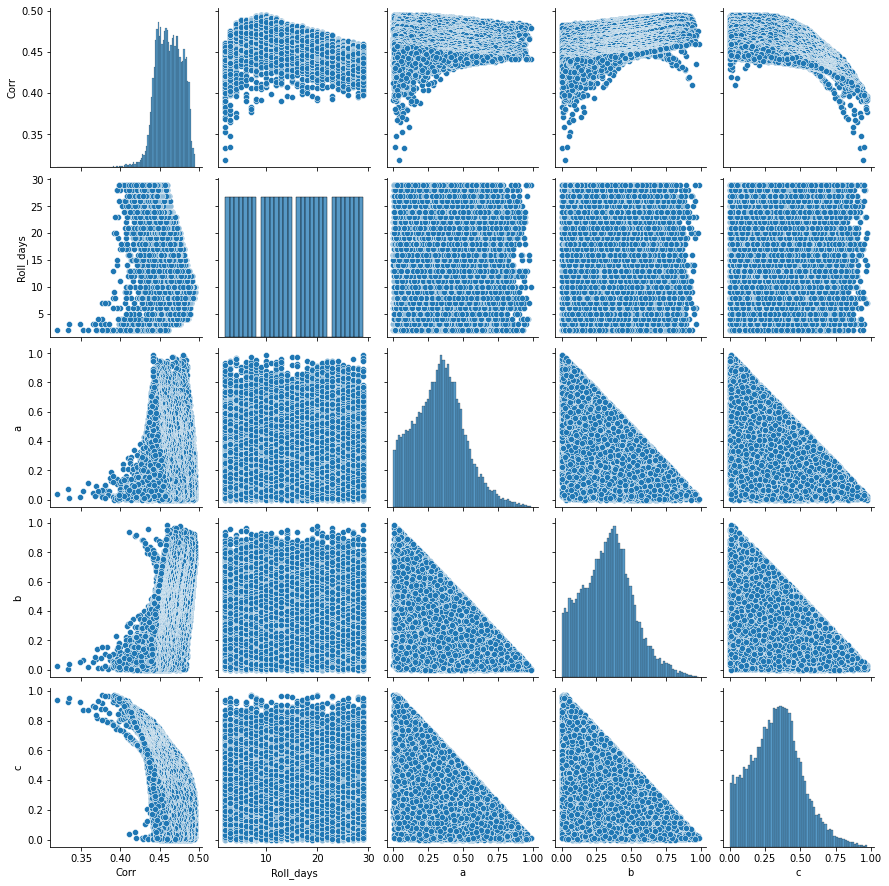

In [ ]:
sns.pairplot(dataf)




---


Nous remarquons l'existence d'un pic pour un quadruplet (Roll_days, a, b, c).

Une tendance à vouloir minimiser a et c, maximiser b et chercher une valeur optimale de Roll_days aux alentours du jour 10.

---



In [ ]:
x0 = Coff_corellation.index(max(Coff_corellation))
a, b, c, Roll_d = As[x0], Bs[x0], Cs[x0], Roll_days[x0]
print("La valeur de a : ", np.round(a,2))
print("La valeur de b : ", np.round(b,2))
print("La valeur de c : ", np.round(c,2))
print("La valeur de Roll_days : ", Roll_d)
print("La valeur maximale du coefficient de correlation est : ", np.round(max(Coff_corellation),2))

La valeur de a :  0.03
La valeur de b :  0.78
La valeur de c :  0.19
La valeur de Roll_days :  10
La valeur maximale du coefficient de correlation est :  0.5




---


Ensuite par l'intermediaire d'une régression, nous allons essayer de prédire $\frac{S_{t+1}}{S_t} - 1$ à partir de notre estimateur pour une période donnée.

Les résultats ne sont pas intéressents, avec un pourcentage de prédiction à **25%** et **une erreur égale** à la valeur moyenne de ma donnée, cette piste s'avère non prometteuse.


---



In [ ]:
Sigmas = np.array(sig(prices, highs, lows, Roll_d, a, b, c)[Roll_d-1:]).reshape(-1,1)
Changes = np.roll(np.absolute(df['Adj Close'].pct_change().to_numpy()[Roll_d-1:]),-1).reshape(-1,1)
model = LinearRegression().fit(Sigmas, Changes)
s = 0
for el in range(len(Sigmas)):
  r_sq = model.predict([Sigmas[el]])
  s += (r_sq[0][0] - Changes[el][0])**2
s = s/len(Sigmas)
print("La moyenne des évolutions des prix entre t et t+1 est : ", np.round(np.mean(Changes),4))
print("La moyenne des erreurs de prediction est : ", np.round(s**(1/2),4))
print("Le pourcentage de predictions justes est : ", np.round(100*model.score(Sigmas,Changes),2), "%.")

La moyenne des évolutions des prix entre t et t+1 est :  0.0098
La moyenne des erreurs de prediction est :  0.0089
Le pourcentage de predictions justes est :  24.52 %.


Voici une potentielle implémentation de cette méthode afin de produire des $K_u$ et $K_d$.

$K_u$ = $max(1 + prédiction,1)$

$K_d$ = $min(1 - prédiction,1)$

et ceci pour chaque Lookback.

In [ ]:
def Teta2(prices, highs, lows, st, t, K, T, Roll_d, a, b, c):
  Supp_Ku = np.ones(T, dtype = np.float64)
  Supp_Kd = np.ones(T, dtype = np.float64)
  for i in range(T):
    input = prices[i:]
    input_highs = highs[i:]
    input_lows = lows[i:]
    today = input[-1]
    sigma1 = sig(input,input_highs,input_lows, Roll_d,a,b,c)
    Ku = 1 + model.predict([sigma1])[0][0]
    Kd = 1 - model.predict([sigma1])[0][0]
    Supp_Ku[i] = max(Ku,1)
    Supp_Kd[i] = min(max(Kd,0),1)
  qte: float = 0
  V0 : float = 0
  if t == 0:
    V0 = g(int(t), int(T), float(K), Supp_Ku, Supp_Kd, float(st))
    qte = (g(int(t+1), int(T), float(K), Supp_Ku, Supp_Kd, float(Supp_Ku[t]*st)) - g(int(t+1), int(T), float(K), Supp_Ku, Supp_Kd, float(Supp_Kd[t]*st))) / ((Supp_Ku[t] - Supp_Kd[t])*st)
  else:
    qte = (g(int(t+1), int(T), float(K), Supp_Ku, Supp_Kd, float(Supp_Ku[t]*st)) - g(int(t+1), int(T), float(K), Supp_Ku, Supp_Kd, float(Supp_Kd[t]*st))) / ((Supp_Ku[t] - Supp_Kd[t])*st)

  return qte, V0



---


**Conclusion :**

- La méthode des intervalles de confiance est flexible elle permet de réduire le nombre de paramètres de $K_u$, $K_d$ à un simple pourcentage de confiance. Une hypothèse a été prise sur la répartition des prix $S_t$ qui peut s'avérer fausse dans des cas spéciaux.
- La méthode des ratios de volatilités est interessente mais ne disposent d'aucun paramètre (sauf le lookback qui est un paramètre commun à toutes les stratégies), de ce fait, n'est pas flexible, elle produit des résultats assez bon avec des taux de réplication > 90%.
- La dernière méthode est une tentative pour créer un estimateur calibrer sur la donnée existante afin de prédire les futures mouvements du marché => le Support de $S_{t+1}$. Mais avec un coefficient de **corrélation de 50%**, le **taux maximum de prédiction sera 25%** (le carré du coefficient de corrélation), il faudra améiorer l'estimateur afin d'avoir des valeurs de correlations plus importantes.
---

